In [28]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

Para el EDA, necesitamos responder cuales de las columnas de esta base de datos nos ayuda a lograr los objetivos del proyecto:

- Crear un sistema de recomendacion de videojuegos para usuarios con las consultas requeridas


Y cuales relacionan esta base con las otras bases. Esos seran nuestros objetivos en este EDA. Para este proposito tambien utilizaremos el nuevo Diccionario de Datos.

In [29]:
# Cargar el conjunto de datos user_reviews
user_reviews = pd.read_parquet('user_reviews.parquet')

In [30]:
# Mostrar las primeras filas de cada DataFrame
print("Primeras y ultimas filas de user_reviews:")
user_reviews

Primeras y ultimas filas de user_reviews:


,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,sentiment_analysis
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,2
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,2
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,2
3,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,2
4,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,0
...,...,...,...,...,...,...,...,...,...
59300,76561198312638244,http://steamcommunity.com/profiles/76561198312...,,Posted July 10.,,70,No ratings yet,True,2
59301,76561198312638244,http://steamcommunity.com/profiles/76561198312...,,Posted July 8.,,362890,No ratings yet,True,2
59302,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,1 person found this review funny,Posted July 3.,,273110,1 of 2 people (50%) found this review helpful,True,2
59303,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,,Posted July 20.,,730,No ratings yet,True,2


In [31]:
# Obtener información sobre los DataFrames
print("\nInformación de user_reviews:")
print(user_reviews.info())


Información de user_reviews:
<class 'pandas.core.frame.DataFrame'>
Index: 58431 entries, 0 to 59304
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             58431 non-null  object
 1   user_url            58431 non-null  object
 2   funny               58431 non-null  object
 3   posted              58431 non-null  object
 4   last_edited         58431 non-null  object
 5   item_id             58431 non-null  int64 
 6   helpful             58431 non-null  object
 7   recommend           58431 non-null  bool  
 8   sentiment_analysis  58431 non-null  int64 
dtypes: bool(1), int64(2), object(6)
memory usage: 4.1+ MB
None


In [32]:
# Verificar la forma (número de filas y columnas) del DataFrame
print("\nForma de user_reviews:", user_reviews.shape)


Forma de user_reviews: (58431, 9)


In [33]:
# Verificar valores faltantes en cada DataFrame
print("\nValores faltantes en user_reviews:")
print(user_reviews.isnull().sum())


Valores faltantes en user_reviews:
user_id               0
user_url              0
funny                 0
posted                0
last_edited           0
item_id               0
helpful               0
recommend             0
sentiment_analysis    0
dtype: int64


Realizando estas consultas basicas vemos que el preprocesamiento de user_reviews ha sido hecho correctamente, ya que no hay objetos con tipos de datos que imposibiliten su utilizacion y tampoco hay datos faltantes.

Siendo asi pasamos a responder nuestras preguntas. Cuales de estas columnas nos ayudan con nuestro objetivo y cuales conectan a esta base con las demas? Separemos las que sí sirven y las que no:


SI

- user_id: Conecta esta base con users_items.parquet (user_id).
- item_id: Conecta con steam_games.parquet.parquet (id) y con users_items.parquet (item_id).
- recommend: ya que estamos desarrollando un sistema de recomendacion, esta columna sera util por obvias razones.
- sentiment_analysis: contiene datos importantes para el sistema de recomendacion (promotores, neutros y detractores)

NO
- user_url
- funny
- posted
- last_edited
- helpful

eliminaremos las columnas que no sirven.

In [34]:
# Lista de columnas a eliminar
columnas_a_eliminar = ['user_url', 'funny', 'posted', 'last_edited', 'helpful']

# Eliminar las columnas del DataFrame user_reviews
user_reviews = user_reviews.drop(columnas_a_eliminar, axis=1)

In [35]:
# Mostrar las primeras filas de cada DataFrame
print("Primeras y ultimas filas de user_reviews:")
user_reviews

Primeras y ultimas filas de user_reviews:


,user_id,item_id,recommend,sentiment_analysis
0,76561197970982479,1250,True,2
1,76561197970982479,22200,True,2
2,76561197970982479,43110,True,2
3,js41637,251610,True,2
4,js41637,227300,True,0
...,...,...,...,...
59300,76561198312638244,70,True,2
59301,76561198312638244,362890,True,2
59302,LydiaMorley,273110,True,2
59303,LydiaMorley,730,True,2


In [36]:
user_reviews_pyarrow = pa.Table.from_pandas(user_reviews)
pq.write_table(user_reviews_pyarrow, "user_reviews.parquet")

Una vez que tenemos los datos utiles y limpios, realizaremos una revision de los porcentajes de recomendados y de Promotores, Neutros y Detractores

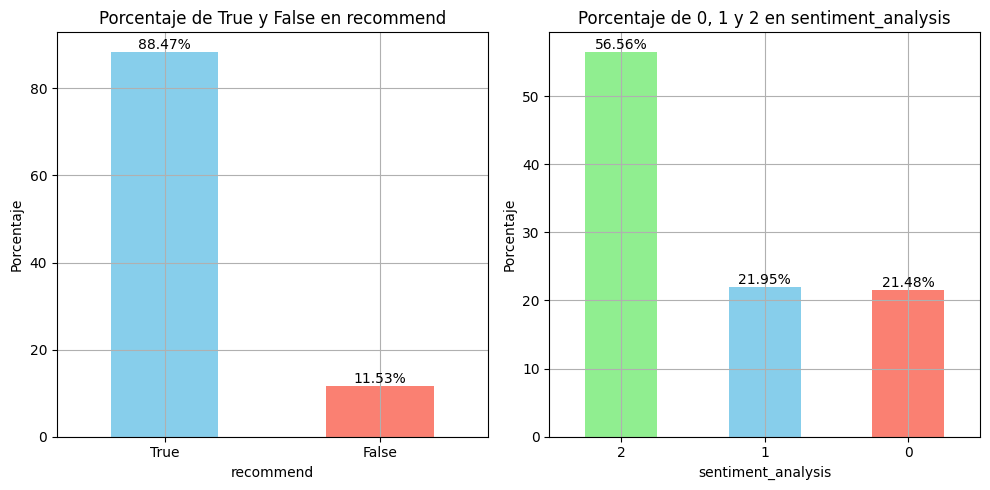

In [37]:
# Obtener el conteo de valores en la columna recommend
recommend_counts = user_reviews['recommend'].value_counts(normalize=True) * 100

# Obtener el conteo de valores en la columna sentiment_analysis
sentiment_counts = user_reviews['sentiment_analysis'].value_counts(normalize=True) * 100

# Crear gráfico de barras para la columna recommend
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
recommend_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Porcentaje de True y False en recommend')
plt.xlabel('recommend')
plt.ylabel('Porcentaje')
plt.xticks(rotation=0)
plt.grid(True)

# Agregar etiquetas de porcentaje para cada barra en el primer gráfico
for i, value in enumerate(recommend_counts):
    plt.text(i, value, f'{value:.2f}%', ha='center', va='bottom')

# Crear gráfico de barras para la columna sentiment_analysis
plt.subplot(1, 2, 2)
sentiment_counts.plot(kind='bar', color=['lightgreen', 'skyblue', 'salmon'])
plt.title('Porcentaje de 0, 1 y 2 en sentiment_analysis')
plt.xlabel('sentiment_analysis')
plt.ylabel('Porcentaje')
plt.xticks(rotation=0)
plt.grid(True)

# Agregar etiquetas de porcentaje para cada barra en el segundo gráfico
for i, value in enumerate(sentiment_counts):
    plt.text(i, value, f'{value:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Segun el grafico, existe un 9.95% de usuarios que dieron un review negativo, pero recomendarion el juego. Luego de una pequeña revision se constata que, de hecho, se da dicho escenario.